In [ ]:
!pip install timm
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
from torchvision import transforms, datasets
from torchvision import models
from torch.utils.data import DataLoader

import timm
from timm.loss import LabelSmoothingCrossEntropy

import torchinfo

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

#**Data Augmentation**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomRotation((0, 90)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

data_transforms_val_test = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
])

data_dir = '/content/drive/MyDrive/Deep Learning & Optimization/hymenoptera_data'

train_dataset = datasets.ImageFolder(data_dir + '/train', data_transforms)
val_dataset = datasets.ImageFolder(data_dir + '/val', data_transforms_val_test)
test_dataset = datasets.ImageFolder(data_dir + '/test', data_transforms_val_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
print("Class: ", train_dataset.classes)

Class:  ['ants', 'bees']


Label : ants


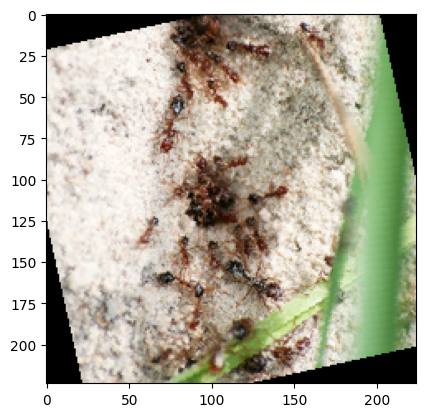

In [ ]:
# Coba menampilkan salah satu gambar setelah ditransform
def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

display_img(*train_dataset[0])

# **Creating Model (Swin Transformer)**

In [ ]:
dev = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = torch.device(dev)

print(device)

cuda


In [ ]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"

model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)
print(model)

In [ ]:
#freeze model
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_dataset.classes))
)
model = model.to(device)
print(model)

In [ ]:
torchinfo.summary(model, (64, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformer                                    [64, 2]                   --
├─PatchEmbed: 1-1                                  [64, 3136, 96]            --
│    └─Conv2d: 2-1                                 [64, 96, 56, 56]          (4,704)
│    └─LayerNorm: 2-2                              [64, 3136, 96]            (192)
├─Dropout: 1-2                                     [64, 3136, 96]            --
├─ModuleList: 1-3                                  --                        --
│    └─BasicLayer: 2-3                             [64, 784, 192]            --
│    │    └─ModuleList: 3-1                        --                        (224,694)
│    │    └─PatchMerging: 3-2                      [64, 784, 192]            (74,496)
│    └─BasicLayer: 2-4                             [64, 196, 384]            --
│    │    └─ModuleList: 3-3                        --                        (891,756)
│    │ 

In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.01)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    exp_lr_scheduler.step()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 1/100, Training Loss: 0.8055290679136912, Validation Loss: 0.3713905870914459
Epoch 2/100, Training Loss: 0.533499080176447, Validation Loss: 0.30312962681055067
Epoch 3/100, Training Loss: 0.4353339090651157, Validation Loss: 0.38678874522447587
Epoch 4/100, Training Loss: 0.4152698528532888, Validation Loss: 0.2428644120693207
Epoch 5/100, Training Loss: 0.27323466656254786, Validation Loss: 0.22944824248552323
Epoch 6/100, Training Loss: 0.29228416523512674, Validation Loss: 0.23471792191267013
Epoch 7/100, Training Loss: 0.272721044865309, Validation Loss: 0.2307078316807747
Epoch 8/100, Training Loss: 0.2830522516194512, Validation Loss: 0.26668339520692824
Epoch 9/100, Training Loss: 0.268692540771821, Validation Loss: 0.24430770725011824
Epoch 10/100, Training Loss: 0.238944774164873, Validation Loss: 0.23570089042186737
Epoch 11/100, Training Loss: 0.25326987662736106, Validation Loss: 0.23998235166072845
Epoch 12/100, Training Loss: 0.24678267158713996, Validation Loss: 

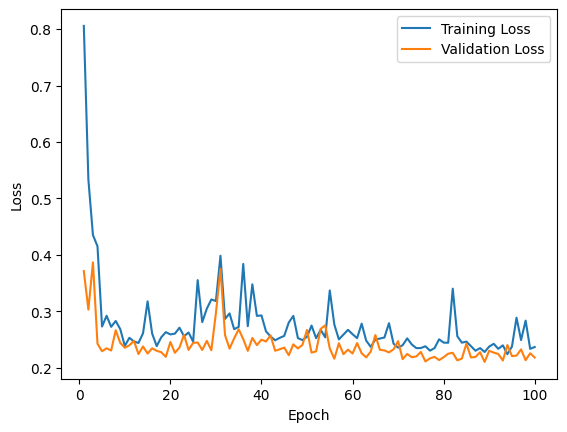

In [ ]:
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_pred_probs.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    y_pred_probs = np.array(y_pred_probs)
    y_true = np.array(y_true)

    return y_true, y_pred_probs

In [ ]:
# Evaluate on the test set
y_true, y_pred_probs = evaluate_model(model, test_loader, device)

y_pred_labels_one_hot = (y_pred_probs > 0.5).astype(int)
y_pred_labels_int = np.argmax(y_pred_labels_one_hot, axis=1)

class_report = classification_report(y_true, y_pred_labels_int, target_names=['ants', 'bees'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

        ants       0.91      1.00      0.95        20
        bees       1.00      0.90      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



# **Creating Model (Visual Transformer)**

In [ ]:
MODEL_NAME2 = "vit_base_patch16_224"

model2 = timm.create_model(MODEL_NAME2, pretrained=True)
print(model2)

In [ ]:
#freeze model
for param in model2.parameters():
    param.requires_grad = False

n_inputs2 = model2.head.in_features
model2.head = nn.Sequential(
    nn.Linear(n_inputs2, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(train_dataset.classes))
)
model2 = model2.to(device)
print(model2)

In [ ]:
torchinfo.summary(model2, (64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [64, 2]                   152,064
├─PatchEmbed: 1-1                        [64, 196, 768]            --
│    └─Conv2d: 2-1                       [64, 768, 14, 14]         (590,592)
│    └─Identity: 2-2                     [64, 196, 768]            --
├─Dropout: 1-2                           [64, 197, 768]            --
├─Identity: 1-3                          [64, 197, 768]            --
├─Identity: 1-4                          [64, 197, 768]            --
├─Sequential: 1-5                        [64, 197, 768]            --
│    └─Block: 2-3                        [64, 197, 768]            --
│    │    └─LayerNorm: 3-1               [64, 197, 768]            (1,536)
│    │    └─Attention: 3-2               [64, 197, 768]            (2,362,368)
│    │    └─Identity: 3-3                [64, 197, 768]            --
│    │    └─Identity: 3-4                [64, 197, 768]    

In [ ]:
criterion2 = LabelSmoothingCrossEntropy()
criterion2 = criterion2.to(device)
optimizer2 = optim.AdamW(model2.head.parameters(), lr=0.01)
exp_lr_scheduler2 = optim.lr_scheduler.StepLR(optimizer2, step_size=3, gamma=0.97)

In [ ]:
num_epochs2 = 100
train_losses2 = []
val_losses2 = []

for epoch in range(num_epochs2):
    model2.train()
    running_loss2 = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer2.zero_grad()
        outputs = model2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()

        running_loss2 += loss.item()

    train_losses2.append(running_loss2 / len(train_loader))

    model2.eval()
    val_loss2 = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model2(inputs)
            loss = criterion2(outputs, labels)
            val_loss2 += loss.item()

    exp_lr_scheduler2.step()

    val_losses2.append(val_loss2 / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs2}, Training Loss: {train_losses2[-1]}, Validation Loss: {val_losses2[-1]}")

Epoch 1/100, Training Loss: 2.724167671858096, Validation Loss: 1.2897140741348267
Epoch 2/100, Training Loss: 2.335603590105094, Validation Loss: 1.2443362593650817
Epoch 3/100, Training Loss: 1.196605214885637, Validation Loss: 0.5296295017004014
Epoch 4/100, Training Loss: 0.6920289625139797, Validation Loss: 0.5332469999790191
Epoch 5/100, Training Loss: 0.44677772562877804, Validation Loss: 0.39344763904809954
Epoch 6/100, Training Loss: 0.4024902815912284, Validation Loss: 0.3962370797991753
Epoch 7/100, Training Loss: 0.3882906597618963, Validation Loss: 0.23693796694278718
Epoch 8/100, Training Loss: 0.347182205786892, Validation Loss: 0.23554608970880508
Epoch 9/100, Training Loss: 0.3551643067130856, Validation Loss: 0.3848993733525276
Epoch 10/100, Training Loss: 0.44197918445456263, Validation Loss: 0.6120733946561814
Epoch 11/100, Training Loss: 0.5582662934766096, Validation Loss: 0.5242341309785843
Epoch 12/100, Training Loss: 0.8964424814079323, Validation Loss: 0.29899

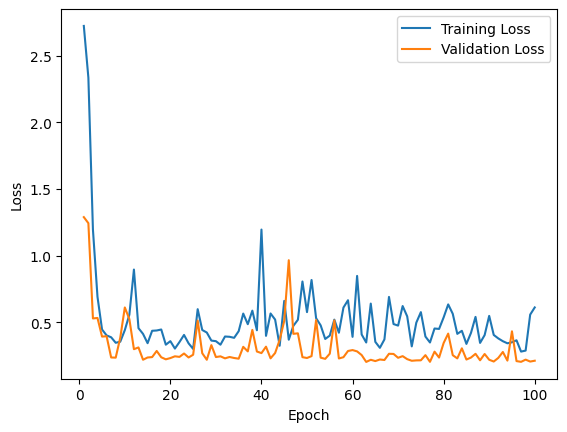

In [ ]:
plt.plot(range(1, num_epochs2 + 1), train_losses2, label="Training Loss")
plt.plot(range(1, num_epochs2 + 1), val_losses2, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Evaluate on the test set
y_true2, y_pred_probs2 = evaluate_model(model2, test_loader, device)

y_pred_labels_one_hot2 = (y_pred_probs2 > 0.5).astype(int)
y_pred_labels_int2 = np.argmax(y_pred_labels_one_hot2, axis=1)

class_report2 = classification_report(y_true2, y_pred_labels_int2, target_names=['ants', 'bees'])
print("Classification Report:\n", class_report2)

Classification Report:
               precision    recall  f1-score   support

        ants       0.87      1.00      0.93        20
        bees       1.00      0.85      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40

